In [ ]:
!pip install sqlalchemy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Импортируем библиотеки

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine 

### Подключение к базе данных

In [ ]:
db_config = { 

}  

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [ ]:
engine = create_engine(connection_string) 

In [ ]:
def select(sql):
  return pd.read_sql(sql,engine)

### Работаем с базой

In [ ]:
sql = ''' SELECT * 
          FROM online_store.profiles 
          LIMIT 5 '''

In [ ]:
select(sql)

,user_id,first_ts,channel,device,region,dt,month,payer
0,10964006,2020-06-25 04:50:17,Yandex,Mac,Germany,2020-06-25,2020-06-01,True
1,12358165,2020-06-23 23:16:24,Yandex,iPhone,United States,2020-06-23,2020-06-01,False
2,12545358,2020-06-18 19:22:46,Organic,Mac,United States,2020-06-18,2020-06-01,False
3,16165560,2020-06-23 20:29:59,Yandex,PC,United States,2020-06-23,2020-06-01,False
4,17733464,2020-06-25 11:08:25,Organic,iPhone,France,2020-06-25,2020-06-01,True


Расчёт Lifetime Value

In [ ]:
sql = ''' SELECT p.channel,
                SUM(o.revenue) / COUNT(DISTINCT o.user_id) AS ltv
      FROM online_store.orders o
      JOIN online_store.profiles p ON o.user_id = p.user_id
      GROUP BY p.channel; '''
select(sql)       

,channel,ltv
0,AnotherSource,7.639834
1,Organic,9.113700
2,Yandex,9.074909


Динамика возврата инвестиций

In [ ]:
sql = ''' SELECT dc.dt,
                revenue * 100 / costs AS ROI
        FROM
          (SELECT dt,
                  SUM(costs) AS costs
          FROM online_store.costs
          GROUP BY dt) dc
        JOIN
          (SELECT event_dt AS dt,
                  SUM(revenue) AS revenue
          FROM online_store.orders
          GROUP BY event_dt) dr ON dc.dt = dr.dt '''
select(sql)             
      

,dt,roi
0,2020-06-14,117.973074
1,2020-06-23,324.570705
2,2020-06-15,197.218689
3,2020-06-19,254.829793
4,2020-06-17,293.187168
5,2020-06-25,402.675612
6,2020-06-18,326.756430
7,2020-06-16,289.513294
8,2020-06-24,341.818276
9,2020-06-22,321.781248


Суммарная стоимость заказов за каждый месяц.

In [ ]:
sql = ''' SELECT *,
        SUM(total_amt) OVER (PARTITION BY DATE_TRUNC('month', created_at))  AS total
        FROM tools_shop.orders
        LIMIT 5 '''
select(sql)       

,order_id,user_id,total_amt,items_cnt,created_at,paid_at,total
0,280567,145,387.50,2,2016-03-12 05:53:55,2016-03-14 18:53:11,500.40
1,278543,219,64.50,3,2016-03-30 06:58:01,2016-03-29 03:42:24,500.40
2,324983,211,48.40,1,2016-03-26 22:43:41,2016-03-27 00:10:43,500.40
3,62705,100,209.00,2,2016-04-26 23:03:56,2016-04-29 11:37:39,568.97
4,349554,682,13.32,4,2016-04-27 16:08:40,2016-04-28 05:12:27,568.97


Общая выручка по месяцам.

In [ ]:
sql = ''' SELECT *,
              SUM(total_amt) OVER (PARTITION BY DATE_TRUNC('month', created_at) )
          FROM tools_shop.orders
          LIMIT 5'''

In [ ]:
select(sql)

,order_id,user_id,total_amt,items_cnt,created_at,paid_at,sum
0,280567,145,387.50,2,2016-03-12 05:53:55,2016-03-14 18:53:11,500.40
1,278543,219,64.50,3,2016-03-30 06:58:01,2016-03-29 03:42:24,500.40
2,324983,211,48.40,1,2016-03-26 22:43:41,2016-03-27 00:10:43,500.40
3,62705,100,209.00,2,2016-04-26 23:03:56,2016-04-29 11:37:39,568.97
4,349554,682,13.32,4,2016-04-27 16:08:40,2016-04-28 05:12:27,568.97


Расчёт кумулятивных значений

In [ ]:
sql = '''SELECT CAST(DATE_TRUNC('month', created_at) AS date),
                total_amt,
                SUM(total_amt) OVER(ORDER BY DATE_TRUNC('month', created_at))
        FROM tools_shop.orders 
        LIMIT 5'''
select(sql)

,date_trunc,total_amt,sum
0,2016-03-01,387.50,500.40
1,2016-03-01,64.50,500.40
2,2016-03-01,48.40,500.40
3,2016-04-01,209.00,1069.37
4,2016-04-01,13.32,1069.37


In [ ]:
sql = '''SELECT user_id,
              created_at,
              total_amt,
              SUM(total_amt) OVER (PARTITiON BY user_id ORDER BY created_at)
        FROM tools_shop.orders
        LIMIT 5'''
select(sql)

,user_id,created_at,total_amt,sum
0,17,2016-05-24 22:00:27,243.00,243.00
1,25,2016-05-18 21:44:54,1.80,1.80
2,63,2016-07-04 23:19:50,585.00,585.00
3,65,2016-05-11 06:52:32,44.50,44.50
4,69,2016-08-08 09:56:12,9.42,9.42


In [ ]:
sql = '''SELECT event_id,
                event_time,
                user_id,
                LEAD(event_time) OVER (PARTITION BY user_id ORDER BY event_time) - event_time
        FROM tools_shop.events
        LIMIT 5'''
select(sql)

,event_id,event_time,user_id,?column?
0,b9f3f9805f774ca981f5f9fae14499fc,2016-07-03 15:32:52,4,1 days 19:51:00
1,c13ab4ef14c2478c9bfb2e5894cb2fa5,2016-07-05 11:23:52,4,60 days 17:23:51
2,777780e172ef48db91710f14ab833bd9,2016-09-04 04:47:43,4,NaT
3,8d6d43f2dff4426899f3f553a570a951,2016-07-24 10:38:32,8,1 days 06:47:00
4,67afe5b1ecc34084bf090d17f8ef283c,2016-07-25 17:25:32,8,0 days 17:17:00


In [ ]:
sql = '''WITH profile AS (
            SELECT DISTINCT u.user_id,
                  u.created_at AS dat_reg
            FROM tools_shop.users AS u
            JOIN tools_shop.orders AS o ON u.user_id = o.user_id
            WHERE DATE_TRUNC('year', u.created_at) = '2019-01-01'),
        ltv AS (
              SELECT p.user_id,
              DATE_TRUNC('month', dat_reg) :: date,
              EXTRACT('MONTH' FROM AGE(o.created_at, p.dat_reg)) AS lifetime,
              SUM(o.total_amt) OVER(PARTITION BY p.user_id ORDER BY o.created_at) AS t
              FROM profile  AS p
              JOIN tools_shop.orders AS o ON p.user_id = o.user_id )
        SELECT ltv.date_trunc AS data_reg,
              ltv.lifetime,
              ROUND(AVG(t), 2) AS avg_ltv
        FROM ltv
        WHERE ltv.lifetime < 6
        GROUP BY 1, 2
        LIMIT 10'''
select(sql)

,data_reg,lifetime,avg_ltv
0,2019-11-01,0.0,227.18
1,2019-12-01,5.0,327.03
2,2019-07-01,3.0,204.72
3,2019-09-01,5.0,254.00
4,2019-12-01,4.0,324.07
5,2019-02-01,1.0,218.19
6,2019-10-01,2.0,237.42
7,2019-08-01,3.0,273.28
8,2019-10-01,3.0,293.98
9,2019-05-01,5.0,252.84


In [ ]:
sql = '''WITH profile  AS (
            SELECT u.user_id,
                  MIN (DATE_TRUNC('month', e.event_time )) :: date AS data_st
            FROM tools_shop.users AS u
            JOIN tools_shop.orders AS o ON o.user_id = u.user_id
            JOIN tools_shop.events AS e ON e.user_id = u.user_id
            GROUP BY 1),
        cr AS (   
            SELECT data_st,
                  DATE_TRUNC('month', e.event_time) :: date AS data_cr,
                  COUNT(DISTINCT(p.user_id))
            FROM profile AS p
            JOIN tools_shop.events AS e ON e.user_id = p.user_id
            GROUP BY 1, 2 )
        SELECT *,
              LAG(cr.count) OVER(PARTITION BY data_st ORDER BY data_cr) AS crt,
              ROUND((1 - (count ::numeric / LAG(cr.count) OVER(PARTITION BY data_st ORDER BY data_cr)))  * 100.0, 2)
        FROM cr
        LIMIT 10'''
select(sql)

,data_st,data_cr,count,crt,round
0,2016-03-01,2016-03-01,4,NaN,NaN
1,2016-03-01,2016-07-01,2,4.0,50.00
2,2016-03-01,2016-08-01,1,2.0,50.00
3,2016-03-01,2016-09-01,2,1.0,-100.00
4,2016-04-01,2016-04-01,12,NaN,NaN
5,2016-04-01,2016-05-01,5,12.0,58.33
6,2016-04-01,2016-07-01,1,5.0,80.00
7,2016-04-01,2016-08-01,4,1.0,-300.00
8,2016-04-01,2016-09-01,2,4.0,50.00
9,2016-04-01,2016-10-01,1,2.0,50.00


### Расчёта Retention Rate 

In [ ]:
sql = '''
WITH profile AS
  (SELECT user_id,
          dt,
          COUNT(*) OVER (PARTITION BY dt) AS cohort_users_cnt
   FROM online_store.profiles
   WHERE channel = 'Organic'),
sessions AS 
(SELECT user_id,
        session_start::date AS session_date
FROM online_store.sessions
GROUP BY 1,
         2)
SELECT p.dt AS cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
''' 

Переведем в датафрейм и построи тепловую карту 

In [ ]:
retention_rate_df = pd.read_sql_query(sql, con = engine) 

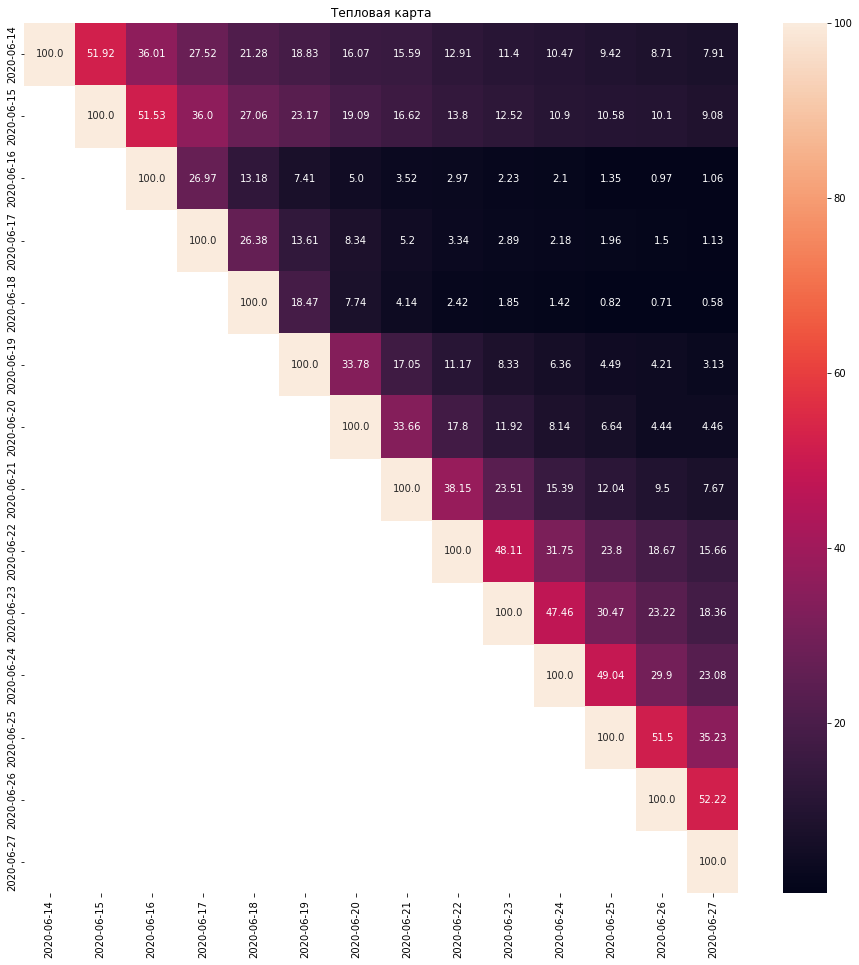

In [ ]:
retention = retention_rate_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 